# Setup

## Imports

In [70]:
import QuantumOptics as qo
using Logging

using LinearAlgebra
using SparseArrays


import CairoMakie as cm

using ProtoStructs

import QuantumOptics.⊗
import QuantumOptics.*

import OrdinaryDiffEq as ODE

import CSV
using JSON
import Tables

using YAXArrays
using DimensionalData

using MiniLoggers
using Dates
using Revise

In [89]:
import SuperconductingCavities as SC

## Extra Stuff

In [90]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

MiniLogger{MiniLoggers.Squash, VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}, VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}, DateFormat{Symbol("yyyy-mm-dd HH:MM:SS"), Tuple{Dates.DatePart{'y'}, Dates.Delim{Char, 1}, Dates.DatePart{'m'}, Dates.Delim{Char, 1}, Dates.DatePart{'d'}, Dates.Delim{Char, 1}, Dates.DatePart{'H'}, Dates.Delim{Char, 1}, Dates.DatePart{'M'}, Dates.Delim{Char, 1}, Dates.DatePart{'S'}}}, typeof(string)}(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(19) open, 0 bytes waiting)), VSCodeServer.io_send_callback), VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Error, Info, Dict{Any, Int64}(), true, MiniLoggers.Token[MiniLoggers.Token("[", MiniLoggers.Color(-

In [91]:
function tostr(obj)
    io = IOBuffer()
    show(io, "text/plain", obj)
    String(take!(io))
end

tostr (generic function with 1 method)

# Doing Stuff

In [92]:
Mode3 = SC.Transmon_Resonators_Loader("ModelSaves/Mode_3/Mode_3.json");

In [93]:
Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]

Dict{String, Any} with 6 entries:
  "pulse_time"    => 177.8
  "Envelope Args" => Dict{String, Any}("pulse_time"=>177.8, "ramp_time"=>10)
  "epsilon"       => 0.88
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0530359
  "freq_d"        => -2.87015

In [113]:
ε = 0.78#Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["epsilon"];
freq_d = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["freq_d"];
println(freq_d)

stark_shifts = collect(LinRange(0.02, 0.08, 21));


-2.870147109080264


## Floquet and Calibrating Pulses

[2024-09-11 17:04:53] Info: Beginning Floquet Sweep
[2024-09-11 17:05:12] Info: Done With Floquet Sweep
[2024-09-11 17:05:12] Info: Tracking State (0, 1)
[2024-09-11 17:05:12] Info: Tracking State (2, 0)
[2024-09-11 17:05:12] Info: Fit Stuff: 3-element Vector{Float64}:	 0.042214294051343304	 0.0025084691480055598	 2.1416665015605254


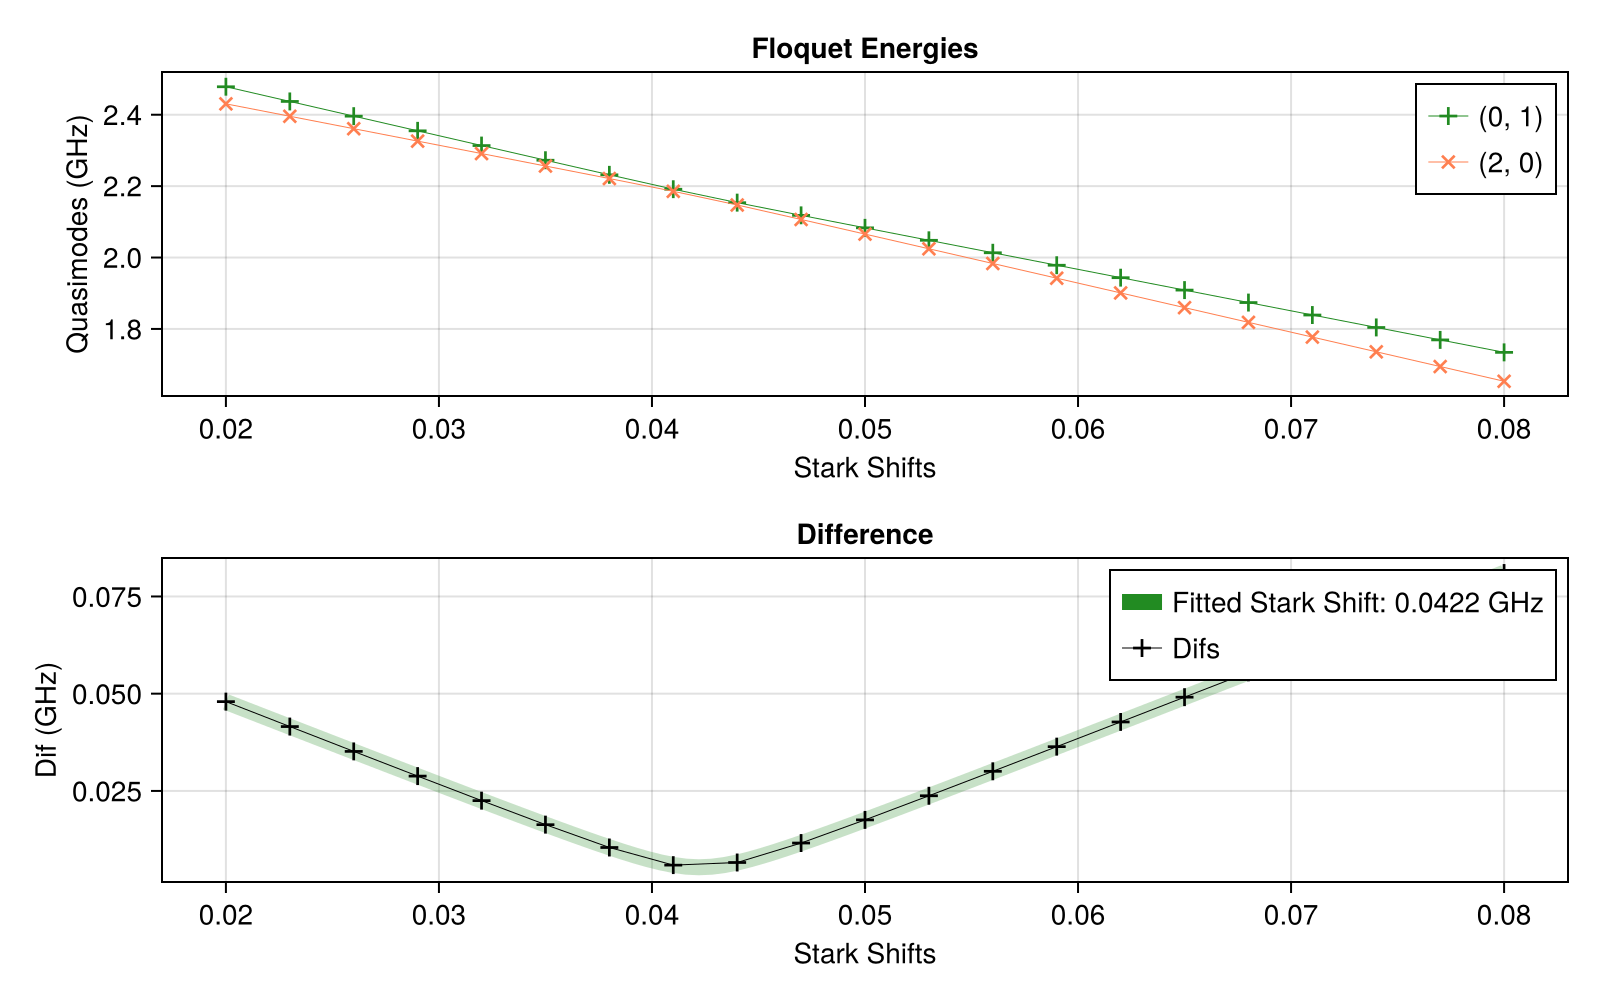

2-element Vector{Float64}:
   0.042214294051343304
 186.1398639909889

In [101]:
stark_shift_res = SC.FindStarkShift(Mode3, Mode3.n̂ₜ, (2,0), (0,1), ε, stark_shifts; make_plot = true)

In [114]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]
stark_shift = stark_shift_res[1]
t0 = stark_shift_res[2]
pulse_time = 198.33
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}("pulse_time" => pulse_time, "ramp_time"=>10)

pulse_args = Dict{Any, Any}("pulse_time" => pulse_time, "shift" => stark_shift, "freq_d" => freq_d, "Envelope"=>envelope, "Envelope Args"=> envelope_args, "epsilon"=> ε)

solver_kwargs = Dict{Any, Any}("reltol" => 1e-4, "abstol"=>1e-4, "tol"=>1e-3, "alg" => ODE.Vern9())
res = SC.RunSingleOperator(Mode3, ψ1, pulse_args, to_return = "Overlaps", save_step = false, solver_kwargs = solver_kwargs);

[2024-09-11 17:49:00] Info: Running Time Evolution
[2024-09-11 17:49:23] Info: Time Evolution Complete
[2024-09-11 17:49:23] Info: Getting Overlaps
[2024-09-11 17:50:15] Info: Done with DEFAULT


In [117]:
res

YAXArray Dataset
Shared Axes: 
(↓ State         Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
→ DEFAULT_Steps Sampled{Int64} [0, 1, …, 991, 992] ForwardOrdered Irregular Points,
↗ Comp          Categorical{String} ["Re", "Im"] ReverseOrdered)
Variables: 
DEFAULT

Properties: Dict{Any, Any}("Data" => "Wave Function Amplitudes", "Basis Shape" => [10, 10], "Solver_Args" => "Dict{Any, Any}(\"reltol\" => 0.0001, \"tol\" => 0.001, \"adaptive\" => true, \"progress\" => true, \"abstol\" => 0.0001, \"alg\" => Vern9(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,))")


In [103]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]
stark_shift = stark_shift_res[1]
t0 = stark_shift_res[2]
t_range = [t0, t0+20]
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}("pulse_time" => 0.0, "ramp_time"=>10)
opt_pulse = SC.OptimizePulse(Mode3, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args)

[2024-09-11 17:33:40] Info: On Level 1
[2024-09-11 17:33:40] Info: On Step 1: t = 186.1398639909889
[2024-09-11 17:33:40] Info: Running Time Evolution
[2024-09-11 17:34:02] Info: Time Evolution Complete
[2024-09-11 17:34:02] Info: Done with Level_1_step_1
[2024-09-11 17:34:02] Info: On Step 2: t = 191.1398639909889
[2024-09-11 17:34:02] Info: Running Time Evolution
[2024-09-11 17:34:25] Info: Time Evolution Complete
[2024-09-11 17:34:25] Info: Done with Level_1_step_2
[2024-09-11 17:34:25] Info: On Step 3: t = 196.1398639909889
[2024-09-11 17:34:25] Info: Running Time Evolution
[2024-09-11 17:34:49] Info: Time Evolution Complete
[2024-09-11 17:34:49] Info: Done with Level_1_step_3
[2024-09-11 17:34:49] Info: On Step 4: t = 201.1398639909889
[2024-09-11 17:34:49] Info: Running Time Evolution
[2024-09-11 17:35:04] Info: Time Evolution Complete
[2024-09-11 17:35:04] Info: Done with Level_1_step_4
[2024-09-11 17:35:04] Info: On Step 5: t = 206.1398639909889
[2024-09-11 17:35:04] Info: Runn

Dict{Any, Any} with 6 entries:
  "pulse_time"    => 197.702
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>197.702, "ramp_time"=>10)
  "epsilon"       => 0.78
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0422143
  "freq_d"        => -2.87015

## Making Plots

In [208]:
dat = open_dataset("Data/Run_Loss_true_2024-09-03T14:34:45.280.nc")

YAXArray Dataset
Shared Axes: 
(↓ State Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered)
Variables: 
Step_1
  (↓ Step_1_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_8
  (↓ Step_8_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_5
  (↓ Step_5_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_9
  (↓ Step_9_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_15
  (↓ Step_15_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_17
  (↓ Step_17_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_11
  (↓ Step_11_Steps Sampled{Int64} 0:1:500 ForwardOrdered Regular Points)
Step_13
  (↓ Step_13_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_2
  (↓ Step_2_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_10
  (↓ Step_10_Steps Sampled{Int64} 0:1:485 ForwardOrdered Regular Points)
Step_18
  (↓ Step_18_Steps Sampled{Int64} 0:1:4857 ForwardOrdered Regular Points)

[2024-09-11 19:01:17] Info: Organizing Data
[2024-09-11 19:01:18] Info: Making Plot


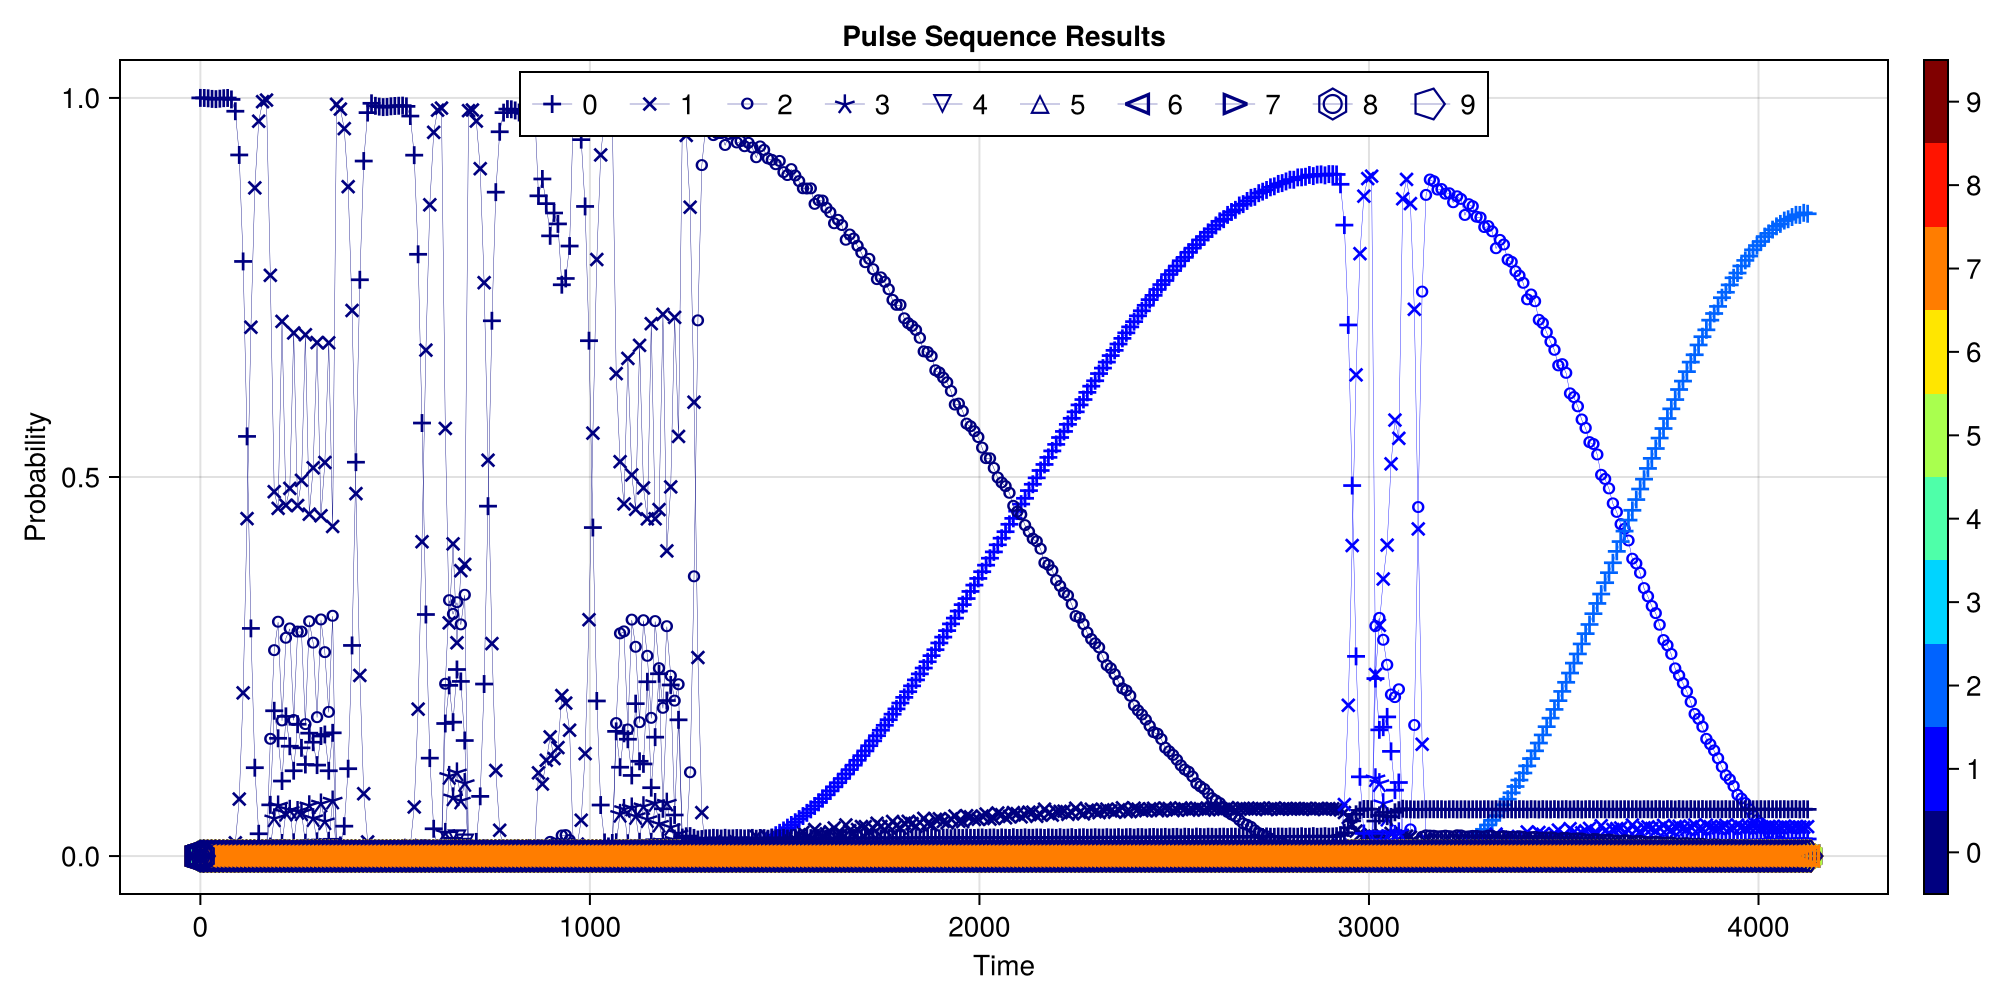

In [214]:
SC.ProbabilityPlotSingleModeEvolution(Mode3, dat, plot_every = 50)